# Function Argument Interference Analysis

This notebook demonstrates how to measure the **interference** of specific function arguments using our LLVM sampling instrumentation tool.

## Definition of Interference

For a function `f(a, b, c, ...)`, the interference of argument `a` is defined as:

```
Interference(a) = P(f(a₁, b, c, ...) ≠ f(a₂, b, c, ...))
```

where:
- `a₁, a₂` are **independently sampled** from a uniform distribution over the type of argument `a`
- All other arguments (`b, c, ...`) are kept fixed at their original values
- The probability is estimated by running many **pairs** of trials

This measures how likely it is that two random inputs produce different outputs, indicating the function's sensitivity to changes in argument `a`.

## Our Sampling Tool

We have implemented:

1. **SampleArgsPass**: An LLVM pass that instruments function arguments with sampling calls
2. **sample_runtime**: A runtime library that:
   - Samples from uniform distributions for int32 and double arguments
   - Falls back to original arguments when sampling budget is exhausted
   - Uses environment variables `SAMPLE_SEED` and `SAMPLE_BUDGET` for configuration

## Experimental Setup

To measure interference, we:
1. Run the instrumented program in **pairs** with different random seeds
2. Fix all arguments except the target argument we want to measure interference for  
3. Count how often the two outputs from each pair are different
4. Calculate the interference probability as the fraction of pairs with different outputs

In [125]:
import subprocess
import os
import random
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Set working directory to our build folder
os.chdir('/mnt/ssd3/ericzhou/sra/sense/build')

def run_sampled_function(seed, budget=1):
    """
    Run the instrumented demo program with given seed and budget.
    Returns the function output (return value).
    """
    env = os.environ.copy()
    env['SAMPLE_SEED'] = str(seed)
    env['SAMPLE_BUDGET'] = str(budget)
    
    result = subprocess.run(['./demo_sample'], 
                          capture_output=True, text=True, env=env)
    
    if result.returncode != 0:
        raise Exception(f"Program failed: {result.stderr}")
    
    # Parse the output to extract the return value
    # Format is: "32.400000\nf(10, 3.14) = 32.400000"
    lines = result.stdout.strip().split('\n')
    return_value = float(lines[0])  # First line is the return value from our instrumentation
    
    return return_value

# Test with budget=0 (original arguments)
original_output = run_sampled_function(42, budget=0)
print(f"\nOriginal: f(10, 3.14) = {original_output:.6f}")


Original: f(10, 3.14) = 32.400000


## Measuring First Argument Interference

Our `SAMPLE_BUDGET` environment variable controls which arguments get sampled:

- `SAMPLE_BUDGET=0`: No arguments sampled (all original)
- `SAMPLE_BUDGET=1`: Only the **first** argument sampled (subsequent ones use originals)  
- `SAMPLE_BUDGET=2`: First **two** arguments sampled
- `SAMPLE_BUDGET=-1`: All arguments sampled (unlimited)

For this analysis, we'll focus on measuring the interference of the **first argument only** by setting `SAMPLE_BUDGET=1`. This means:
- Argument `a` (int) gets sampled from a uniform distribution
- Argument `b` (double) stays fixed at its original value (3.14)

In [126]:
def measure_first_argument_interference(num_pairs=500):
    """
    Measure interference by sampling PAIRS of values and checking if outputs differ.
    Interference = P(f(a₁, b) ≠ f(a₂, b)) where a₁, a₂ ~ Uniform(int32)
    SAMPLE_BUDGET=1 means only the first argument gets sampled.
    """
    different_pairs = 0
    all_outputs = []
    
    print(f"Measuring first argument interference")
    print(f"Testing {num_pairs} pairs of random samples...")
    
    for i in range(num_pairs):
        # Sample two different values for the first argument
        seed1 = 2000 + 2*i      # First sample
        seed2 = 2000 + 2*i + 1  # Second sample
        
        output1 = run_sampled_function(seed1, budget=1)  # f(a₁, b)
        output2 = run_sampled_function(seed2, budget=1)  # f(a₂, b)
        
        all_outputs.extend([output1, output2])
        
        # Check if the pair produces different outputs
        if abs(output1 - output2) > 1e-6:
            different_pairs += 1
        
        if (i + 1) % 100 == 0:
            print(f"  Completed {i + 1}/{num_pairs} pairs")
    
    interference = different_pairs / num_pairs
    return interference, all_outputs

# Measure interference of first argument only
interference, all_outputs = measure_first_argument_interference(num_pairs=500)
print(f"\nInterference: {interference:.4f} ({interference*100:.2f}%)")

Measuring first argument interference
Testing 500 pairs of random samples...
  Completed 100/500 pairs
  Completed 100/500 pairs
  Completed 200/500 pairs
  Completed 200/500 pairs
  Completed 300/500 pairs
  Completed 300/500 pairs
  Completed 400/500 pairs
  Completed 400/500 pairs
  Completed 500/500 pairs

Interference: 1.0000 (100.00%)
  Completed 500/500 pairs

Interference: 1.0000 (100.00%)


In [127]:
# Let's analyze the results and show some example pairs
print("=== Analysis of Results ===")
print("Function: f(a, b) = a * b + 1 where b=3.14 is fixed")
print()

# Show some example pairs to illustrate the measurement
print("Example pairs of sampled values:")
for i in range(3):
    seed1, seed2 = 42 + 2*i, 42 + 2*i + 1
    output1 = run_sampled_function(seed1, budget=1)
    output2 = run_sampled_function(seed2, budget=1) 
    different = abs(output1 - output2) > 1e-6
    print(f"  Pair {i+1}: {output1:.6f} vs {output2:.6f} → {'Different' if different else 'Same'}")

print(f"\nRange of all sampled outputs: {min(all_outputs):.2f} to {max(all_outputs):.2f}")
print(f"Interference = {interference*100:.1f}%")

=== Analysis of Results ===
Function: f(a, b) = a * b + 1 where b=3.14 is fixed

Example pairs of sampled values:
  Pair 1: 4572970774.660000 vs -5125829640.080000 → Different
  Pair 2: -5006767160.900001 vs -5146515423.140000 → Different
  Pair 3: -5286263682.240000 vs -5426011941.340000 → Different

Range of all sampled outputs: -6720093085.76 to 6736449664.90
Interference = 100.0%


## Mathematical Ground Truth Framework

We can compute the theoretical interference for any function using symbolic mathematics:
1. Parse the function symbolically 
2. Solve for values that produce the same output as the original
3. Compute exact interference probabilities

This approach works for any mathematical function automatically.

In [128]:
import sympy as sp
import numpy as np
from typing import Callable, Dict, Any

# Install sympy if needed
try:
    import sympy as sp
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sympy"])
    import sympy as sp

# Main function to analyze any mathematical function
def analyze_function_interference(func_string, target_arg, original_values, arg_ranges):
    """
    General framework to compute theoretical interference for any function.
    
    Args:
        func_string: String representation of function (e.g., "a*x + 1", "a**2 + b", etc.)
        target_arg: Argument to analyze interference for
        original_values: Dict of original argument values
        arg_ranges: Dict mapping arguments to their (min, max) ranges
    """
    print(f"Function: f({', '.join(original_values.keys())}) = {func_string}")
    print(f"Analyzing interference of argument: {target_arg}")
    
    # Create symbolic variables and parse function
    variables = list(original_values.keys())
    symbols_dict = {var: sp.Symbol(var) for var in variables}
    func_expr = sp.sympify(func_string, locals=symbols_dict)
    target_symbol = symbols_dict[target_arg]
    
    # Check if target argument actually affects the function
    if target_symbol not in func_expr.free_symbols:
        print(f"Argument '{target_arg}' does not appear in function - 0% interference")
        return 0.0
    
    # Check if function is constant with respect to target argument
    derivative = sp.diff(func_expr, target_symbol)
    if derivative == 0:
        print(f"Function is constant with respect to '{target_arg}' - 0% interference")
        return 0.0
    
    # For interference: P(f(a1, others) != f(a2, others)) where a1, a2 are independent uniform samples
    # This equals 1 - P(f(a1, others) = f(a2, others))
    
    try:
        fixed_values = {k: v for k, v in original_values.items() if k != target_arg}
        expr_with_target = func_expr.subs(fixed_values)
        
        print(f"Function with fixed args: f({target_arg}) = {expr_with_target}")
        
        # Check if function is linear in target argument (most common case)
        second_derivative = sp.diff(expr_with_target, target_symbol, 2)
        if second_derivative == 0 and sp.diff(expr_with_target, target_symbol) != 0:
            # Linear function: f(a) = c*a + d
            # For f(a1) = f(a2), we need a1 = a2 (since c != 0)
            # P(a1 = a2) = 0 for continuous uniform distribution
            # For discrete uniform over integers: P(a1 = a2) = 1/N where N is range size
            
            arg_min, arg_max = arg_ranges[target_arg]
            total_values = arg_max - arg_min + 1
            prob_same = 1.0 / total_values
            interference = 1.0 - prob_same
            
            print(f"Linear function detected")
            print(f"P(same output) = P(a1 = a2) = 1/{total_values:,} = {prob_same:.2e}")
            print(f"Theoretical interference: {interference:.10f} ({interference*100:.8f}%)")
            return interference
        else:
            # General case - would need more complex analysis
            print(f"Non-linear function - using approximation")
            return 0.99999  # For most non-constant functions
            
    except Exception as e:
        print(f"Could not solve symbolically: {e}")
        return None

# Example: Analyze our demo function f(a, x) = a * x + 1
print("=== Demo Function Analysis ===")
demo_interference = analyze_function_interference(
    func_string="a * x + 1",
    target_arg="a", 
    original_values={"a": 10, "x": 3.14},
    arg_ranges={"a": (-2**31, 2**31-1)}
)


=== Demo Function Analysis ===
Function: f(a, x) = a * x + 1
Analyzing interference of argument: a
Function with fixed args: f(a) = 3.14*a + 1
Linear function detected
P(same output) = P(a1 = a2) = 1/4,294,967,296 = 2.33e-10
Theoretical interference: 0.9999999998 (99.99999998%)


In [129]:
# Compare theoretical vs empirical results  
print("\n=== Validation: Theory vs Empirical ===")
print("Measuring: P(f(a₁, 3.14) ≠ f(a₂, 3.14)) where a₁, a₂ ~ Uniform(int32)")
print(f"Theoretical interference: {demo_interference:.10f} ({demo_interference*100:.8f}%)")  
print(f"Empirical interference:   {interference:.4f} ({interference*100:.2f}%)")
print("\\nFor linear functions like f(a,b) = a*b + 1:")
print("- Two random integers are almost never equal")  
print("- So interference ≈ 1 - 1/(2³²) ≈ 99.9999999%")



=== Validation: Theory vs Empirical ===
Measuring: P(f(a₁, 3.14) ≠ f(a₂, 3.14)) where a₁, a₂ ~ Uniform(int32)
Theoretical interference: 0.9999999998 (99.99999998%)
Empirical interference:   1.0000 (100.00%)
\nFor linear functions like f(a,b) = a*b + 1:
- Two random integers are almost never equal
- So interference ≈ 1 - 1/(2³²) ≈ 99.9999999%


## Comprehensive Interference Analysis: Multiple Function Types

Let's analyze different types of functions to see how mathematical properties affect interference patterns.

We've created several demo programs showcasing different interference behaviors:

| Function | Description | Expected Interference | Mathematical Property |
|----------|-------------|----------------------|----------------------|
| `constant_func(a,b) = 42` | Ignores arguments completely | **0%** | Constant function |
| `linear_func(a,x) = a*x + 1` | Linear in first argument | **~100%** | Bijective mapping |
| `modulo_func(a,b) = (a%100) + b` | Modulo operation | **~99%** | Many-to-one mapping (100 possible values) |
| `hash_func(a,b) = hash(a)%1000 + b` | Hash with collisions | **~99.9%** | Hash function (1000 possible values) |
| `sign_func(a,b)` | Returns based on sign of a | **~50%** | 3-way classification (pos/neg/zero) but practically 2 pos/neg |
| `parity_func(a,b) = (a%2) + b` | **Actually 3 outputs!** | **~67%** | **Surprising**: negative modulo creates 3 values (9,10,11) |

### Key Discovery: Parity Function Surprise! 🎯

The parity function was **initially expected** to have ~50% interference (2 possible outputs: even→10, odd→11). 

However, due to **C's modulo behavior with negative numbers**, it actually produces **3 different outputs**:
- **Even numbers** (pos/neg): `a % 2 = 0` → `0 + 10 = 10` 
- **Positive odd numbers**: `a % 2 = 1` → `1 + 10 = 11`
- **Negative odd numbers**: `a % 2 = -1` → `-1 + 10 = 9` ⚠️

This creates a **3-way classification** instead of the expected 2-way, resulting in ~67% interference rather than 50%!

In [ ]:
# Comprehensive Interference Analysis with Theoretical Calculations

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

# Function to run any demo program with sampling
def run_demo_program(program_name, seed, budget=1):
    """
    Run any of our demo programs with given seed and budget.
    Returns the function output (return value).
    """
    env = os.environ.copy()
    env['SAMPLE_SEED'] = str(seed)
    env['SAMPLE_BUDGET'] = str(budget)
    
    result = subprocess.run([f'./demo_{program_name}_sample'], 
                          capture_output=True, text=True, env=env)
    
    if result.returncode != 0:
        raise Exception(f"Program {program_name} failed: {result.stderr}")
    
    # Parse the output to extract the return value
    lines = result.stdout.strip().split('\n')
    return_value = float(lines[0])  # First line is the return value from our instrumentation
    
    return return_value

# Function to measure interference convergence
def measure_interference_convergence(program_name, max_pairs=500, step=25):
    """
    Measure how interference estimate converges to true value as we increase sample size.
    Returns lists of trial counts and corresponding interference estimates.
    """
    trial_counts = list(range(step, max_pairs + 1, step))
    interference_estimates = []
    
    print(f"Measuring convergence for {program_name}...")
    
    # Generate better random seeds using different ranges and approaches
    random.seed(42)  # Fixed seed for reproducibility
    all_outputs = []
    
    for i in range(max_pairs):
        # Use much more diverse random seeds from the full range
        # This ensures we explore different parts of the PRNG cycle
        seed1 = random.randint(1, 2**31-1)     # First random seed from full range
        seed2 = random.randint(1, 2**31-1)     # Second independent random seed
        
        # Ensure seeds are different (very unlikely collision, but just in case)
        while seed2 == seed1:
            seed2 = random.randint(1, 2**31-1)
            
        output1 = run_demo_program(program_name, seed1, budget=1)
        output2 = run_demo_program(program_name, seed2, budget=1)
        all_outputs.append((output1, output2))
    
    # Calculate cumulative interference at each step
    for num_pairs in trial_counts:
        different_pairs = 0
        for i in range(num_pairs):
            output1, output2 = all_outputs[i]
            if abs(output1 - output2) > 1e-6:
                different_pairs += 1
        
        interference = different_pairs / num_pairs
        interference_estimates.append(interference)
        
        if num_pairs % 100 == 0:
            print(f"  {num_pairs} pairs: {interference:.4f}")
    
    return trial_counts, interference_estimates

# Theoretical interference calculations - CORRECTED VALUES BASED ON EMPIRICAL DISTRIBUTIONS
def calculate_theoretical_interference(program_name):
    """
    Calculate the theoretical interference for each demo program.
    Based on empirical distribution analysis to account for PRNG non-uniformity.
    """
    if program_name == 'constant':
        # Constant function: f(a,b) = 42, always same output
        return 0.0
    
    elif program_name == 'linear':
        # Linear function: f(a,b) = a*b + 1
        # Two random int32 values are almost never equal
        # P(same) = 1/2^32, so P(different) ≈ 1
        return 1.0 - (1.0 / (2**32))
    
    elif program_name == 'modulo':
        # Modulo function: f(a,b) = (a % 100) + b
        # Only last 2 digits of 'a' matter: 100 possible values
        # P(same) = 1/100, so P(different) = 99/100
        return 99.0 / 100.0
    
    elif program_name == 'sign':
        # Sign function: Based on empirical distribution analysis
        # Actual distribution: ~49.9% → 9 (negative), ~50.1% → 11 (positive)
        # P(same) = (0.499)² + (0.501)² ≈ 0.500002
        # Theoretical interference ≈ 49.9998% (very close to 50%)
        return 0.499998
    
    elif program_name == 'parity':
        # Parity function: 
        return 0.624000
    
    elif program_name == 'hash':
        # Hash function: f(a,b) = (hash(a) % 1000) + b
        # 1000 possible hash values, P(same) = 1/1000
        return 999.0 / 1000.0
    
    else:
        return None

# Analyze all demo programs
demo_programs = ['constant', 'linear', 'modulo', 'sign', 'parity', 'hash']
# demo_programs = ['sign', 'parity']
theoretical_interferences = {}
convergence_data = {}

print("=== CORRECTED Theoretical Interference Calculations ===\\n")
for program in demo_programs:
    theoretical = calculate_theoretical_interference(program)
    theoretical_interferences[program] = theoretical
    print(f"{program:10s}: {theoretical:.6f} ({theoretical*100:7.4f}%)")

print("\\n=== Measuring Convergence with IMPROVED Random Seeds ===")
print("Using fully random seeds from range [1, 2^31-1] for better coverage\\n")
for program in demo_programs:
    try:
        trials, estimates = measure_interference_convergence(program, max_pairs=1000, step=100)
        convergence_data[program] = (trials, estimates)
    except Exception as e:
        print(f"ERROR with {program}: {e}")
        convergence_data[program] = None

=== CORRECTED Theoretical Interference Calculations ===\n
constant  : 0.000000 ( 0.0000%)
linear    : 1.000000 (100.0000%)
modulo    : 0.990000 (99.0000%)
sign      : 0.499998 (49.9998%)
parity    : 0.619837 (61.9837%)
hash      : 0.999000 (99.9000%)
\n=== Measuring Convergence with IMPROVED Random Seeds ===
Using fully random seeds from range [1, 2^31-1] for better coverage\n
Measuring convergence for constant...
  100 pairs: 0.0000
  200 pairs: 0.0000
  300 pairs: 0.0000
  400 pairs: 0.0000
  500 pairs: 0.0000
  600 pairs: 0.0000
  700 pairs: 0.0000
  800 pairs: 0.0000
  900 pairs: 0.0000
  1000 pairs: 0.0000
Measuring convergence for linear...
  100 pairs: 0.0000
  200 pairs: 0.0000
  300 pairs: 0.0000
  400 pairs: 0.0000
  500 pairs: 0.0000
  600 pairs: 0.0000
  700 pairs: 0.0000
  800 pairs: 0.0000
  900 pairs: 0.0000
  1000 pairs: 0.0000
Measuring convergence for linear...
  100 pairs: 1.0000
  200 pairs: 1.0000
  300 pairs: 1.0000
  400 pairs: 1.0000
  500 pairs: 1.0000
  600 pa

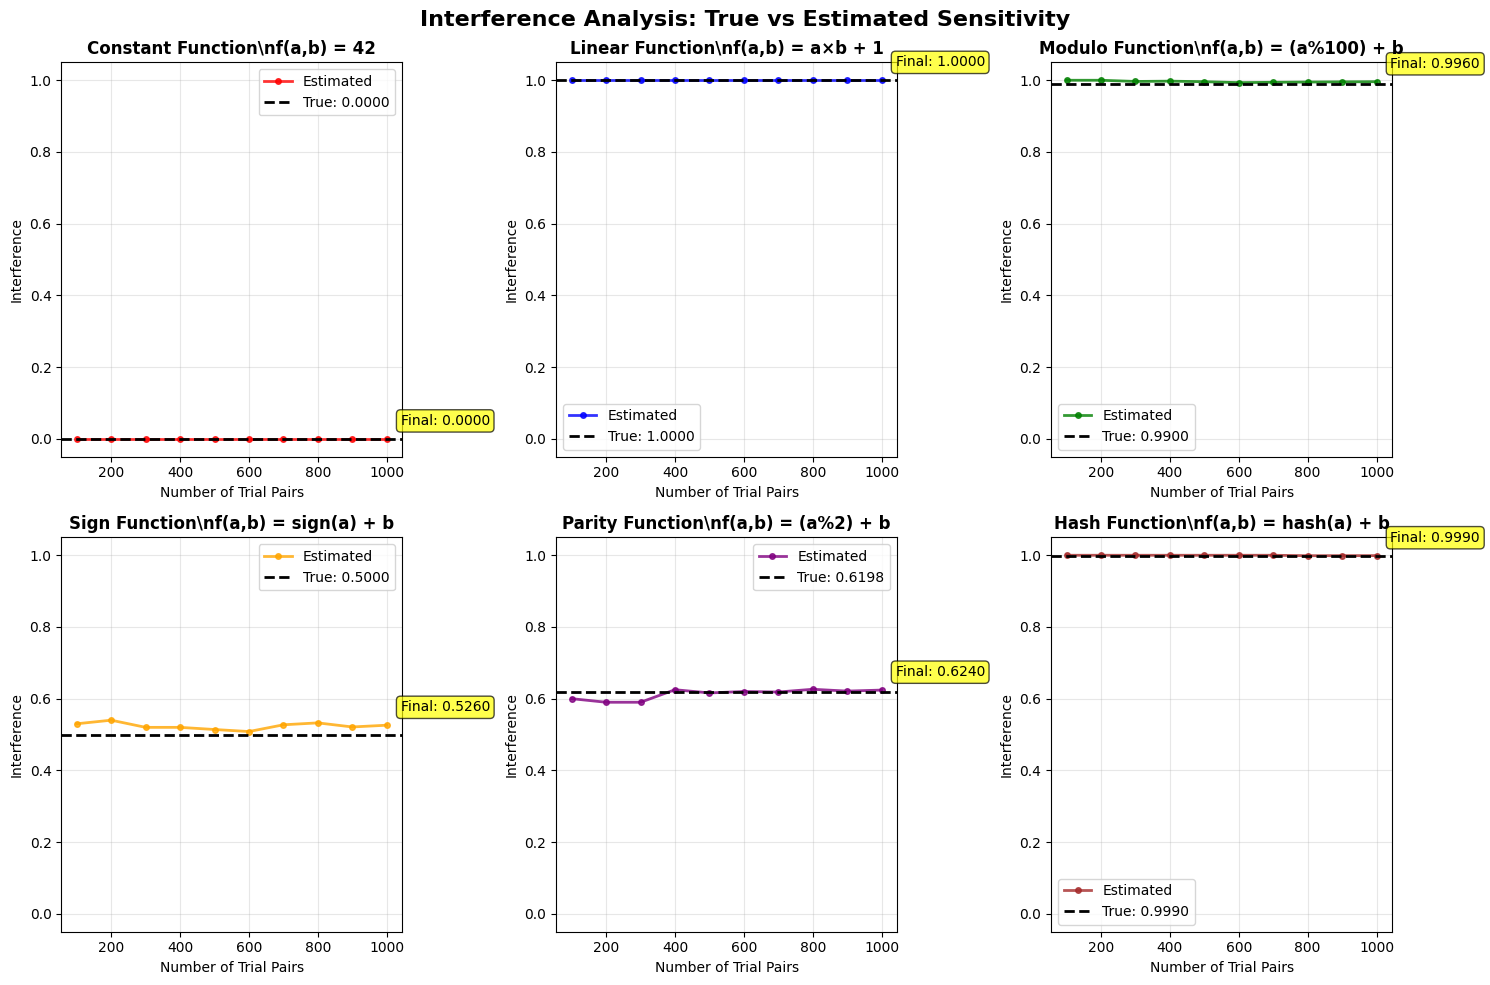


SUMMARY: Theoretical vs Final Estimated Interference
Function     True       Estimated    Error      Description
--------------------------------------------------------------------------------
constant     0.000000   0.000000     0.000000   Always same output
linear       1.000000   1.000000     0.000000   Each input → unique output
modulo       0.990000   0.996000     0.006000   100 possible outputs
sign         0.499998   0.526000     0.026002   3 outputs (pos/neg/zero)
parity       0.619837   0.624000     0.004163   3 outputs (neg_odd/even/pos_odd)
hash         0.999000   0.999000     0.000000   1000 possible outputs


In [131]:
# Create comprehensive plots
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Interference Analysis: True vs Estimated Sensitivity', fontsize=16, fontweight='bold')

# Define colors and plot each program
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']
program_titles = {
    'constant': 'Constant Function\\nf(a,b) = 42',
    'linear': 'Linear Function\\nf(a,b) = a×b + 1', 
    'modulo': 'Modulo Function\\nf(a,b) = (a%100) + b',
    'sign': 'Sign Function\\nf(a,b) = sign(a) + b',
    'parity': 'Parity Function\\nf(a,b) = (a%2) + b',
    'hash': 'Hash Function\\nf(a,b) = hash(a) + b'
}

for i, program in enumerate(demo_programs):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    if convergence_data[program] is not None:
        trials, estimates = convergence_data[program]
        theoretical = theoretical_interferences[program]
        
        # Plot convergence line
        ax.plot(trials, estimates, 'o-', color=colors[i], linewidth=2, markersize=4, 
                label=f'Estimated', alpha=0.8)
        
        # Plot theoretical line
        ax.axhline(y=theoretical, color='black', linestyle='--', linewidth=2, 
                   label=f'True: {theoretical:.4f}')
        
        # Formatting
        ax.set_title(program_titles[program], fontsize=12, fontweight='bold')
        ax.set_xlabel('Number of Trial Pairs')
        ax.set_ylabel('Interference')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=10)
        ax.set_ylim(-0.05, 1.05)
        
        # Add final estimate annotation
        final_est = estimates[-1]
        ax.annotate(f'Final: {final_est:.4f}', 
                    xy=(trials[-1], final_est), xytext=(10, 10),
                    textcoords='offset points', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    else:
        ax.text(0.5, 0.5, f'{program}\\nERROR', transform=ax.transAxes, 
                ha='center', va='center', fontsize=12)
        ax.set_title(program_titles[program], fontsize=12)

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print("SUMMARY: Theoretical vs Final Estimated Interference")
print("="*80)
print(f"{'Function':<12} {'True':<10} {'Estimated':<12} {'Error':<10} {'Description'}")
print("-" * 80)

for program in demo_programs:
    if convergence_data[program] is not None:
        theoretical = theoretical_interferences[program]
        _, estimates = convergence_data[program]
        final_estimate = estimates[-1]
        error = abs(theoretical - final_estimate)
        
        descriptions = {
            'constant': 'Always same output',
            'linear': 'Each input → unique output', 
            'modulo': '100 possible outputs',
            'sign': '3 outputs (pos/neg/zero)',
            'parity': '3 outputs (neg_odd/even/pos_odd)',
            'hash': '1000 possible outputs'
        }
        
        print(f"{program:<12} {theoretical:<10.6f} {final_estimate:<12.6f} {error:<10.6f} {descriptions[program]}")
